# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from collections import defaultdict
from tqdm.notebook import tqdm
import gymnasium as gym

In [38]:
@torch.no_grad()
def eval(env, model, max_episodes, max_episode_steps, get_action_func):
    """
    Test model performance playing environment
    """
    model.eval()

    rewards = []
    steps = []
    for episode_i in range(max_episodes):

        rewards.append(0)
        steps.append(0)

        state, info = env.reset()

        for step_i in range(max_episode_steps):

            action = get_action_func(model, state)

            state, reward, terminated, truncated, info = env.step(action)

            rewards[-1] += reward
            steps[-1] += 1

            if terminated or truncated:
                break

    print(f"Eval: episodes {max_episodes}, average episode sum rewards {np.mean(rewards)}, std {np.std(rewards)}. Average number of steps {np.mean(steps)}, std {np.std(steps)}")

def show_train_curves(train_curves):
    """
    Show training curves with their moving average
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(train_curves))
    fig.set_size_inches(25, 12)

    if len(train_curves) == 1:
        ax = [ax]

    for ci, (label, points) in enumerate(train_curves.items()):

        N = max(2, len(points) // 100)
        cumsum = np.cumsum(np.insert(points, 0, 0))
        moving_average = (cumsum[N:] - cumsum[:-N]) / float(N)

        ax[ci].plot(points, label=label)
        ax[ci].plot(moving_average, linewidth=1, color='r', label=f"Moving average using {N} points window")
        ax[ci].set_ylabel(label)
        ax[ci].legend()
        ax[ci].grid(True)



class ActorCritic_Actor_Model(torch.nn.Module):
    """
    Actor model - for a given state returns actions probability distribution
    """
    def __init__(self, env):
        super().__init__()

        assert len(env.observation_space.shape) == 1

        self.ENV_STATE_SIZE = env.observation_space.shape[0]
        self.ENV_ACTIONS = env.action_space.n

        hidden_size = 64

        self.actor_model = torch.nn.Sequential(
            torch.nn.Linear(self.ENV_STATE_SIZE, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, self.ENV_ACTIONS),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, state):
        B = state.shape[0]  # batch size
        assert state.shape == (B, self.ENV_STATE_SIZE)

        action_probs = self.actor_model(state)
        return action_probs


class ActorCritic_Critic_Model(torch.nn.Module):
    """
    Critic model - for a given state returns its estimated value
    """
    def __init__(self, env):
        super().__init__()

        assert len(env.observation_space.shape) == 1

        self.ENV_STATE_SIZE = env.observation_space.shape[0]

        hidden_size = 64

        self.critic_model = torch.nn.Sequential(
            torch.nn.Linear(self.ENV_STATE_SIZE, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1),
        )

    def forward(self, state):
        B = state.shape[0]  # batch size
        assert state.shape == (B, self.ENV_STATE_SIZE)

        value_estimate = self.critic_model(state)
        return value_estimate


class ActorCritic_TwoHeads_Model(torch.nn.Module):
    """
    One model for policy and state evaluation:
    Actor head - for a given state returns actions probability distribution
    Critic head - for a given state returns its estimated value
    """
    def __init__(self, env):
        super().__init__()

        assert len(env.observation_space.shape) == 1

        self.ENV_STATE_SIZE = env.observation_space.shape[0]
        self.ENV_ACTIONS = env.action_space.n

        hidden_size = 64

        self.common_model = torch.nn.Sequential(
            torch.nn.Linear(self.ENV_STATE_SIZE, hidden_size),
            torch.nn.ReLU(),
        )

        self.actor_action_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, self.ENV_ACTIONS),
            torch.nn.Softmax(dim=1),
        )

        self.critic_value_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 1),
        )

    def forward(self, state):
        B = state.shape[0]  # batch size
        assert state.shape == (B, self.ENV_STATE_SIZE)

        common = self.common_model(state)

        action_probs = self.actor_action_head(common)

        value_estimate = self.critic_value_head(common)

        return action_probs, value_estimate

# Actor-Critic on LunarLander

Implementation based on: https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py

  0%|          | 0/10000 [00:00<?, ?it/s]

Eval: episodes 100, average episode sum rewards 104.93392157992666, std 24.908486213757534. Average number of steps 991.29, std 61.37056216134899


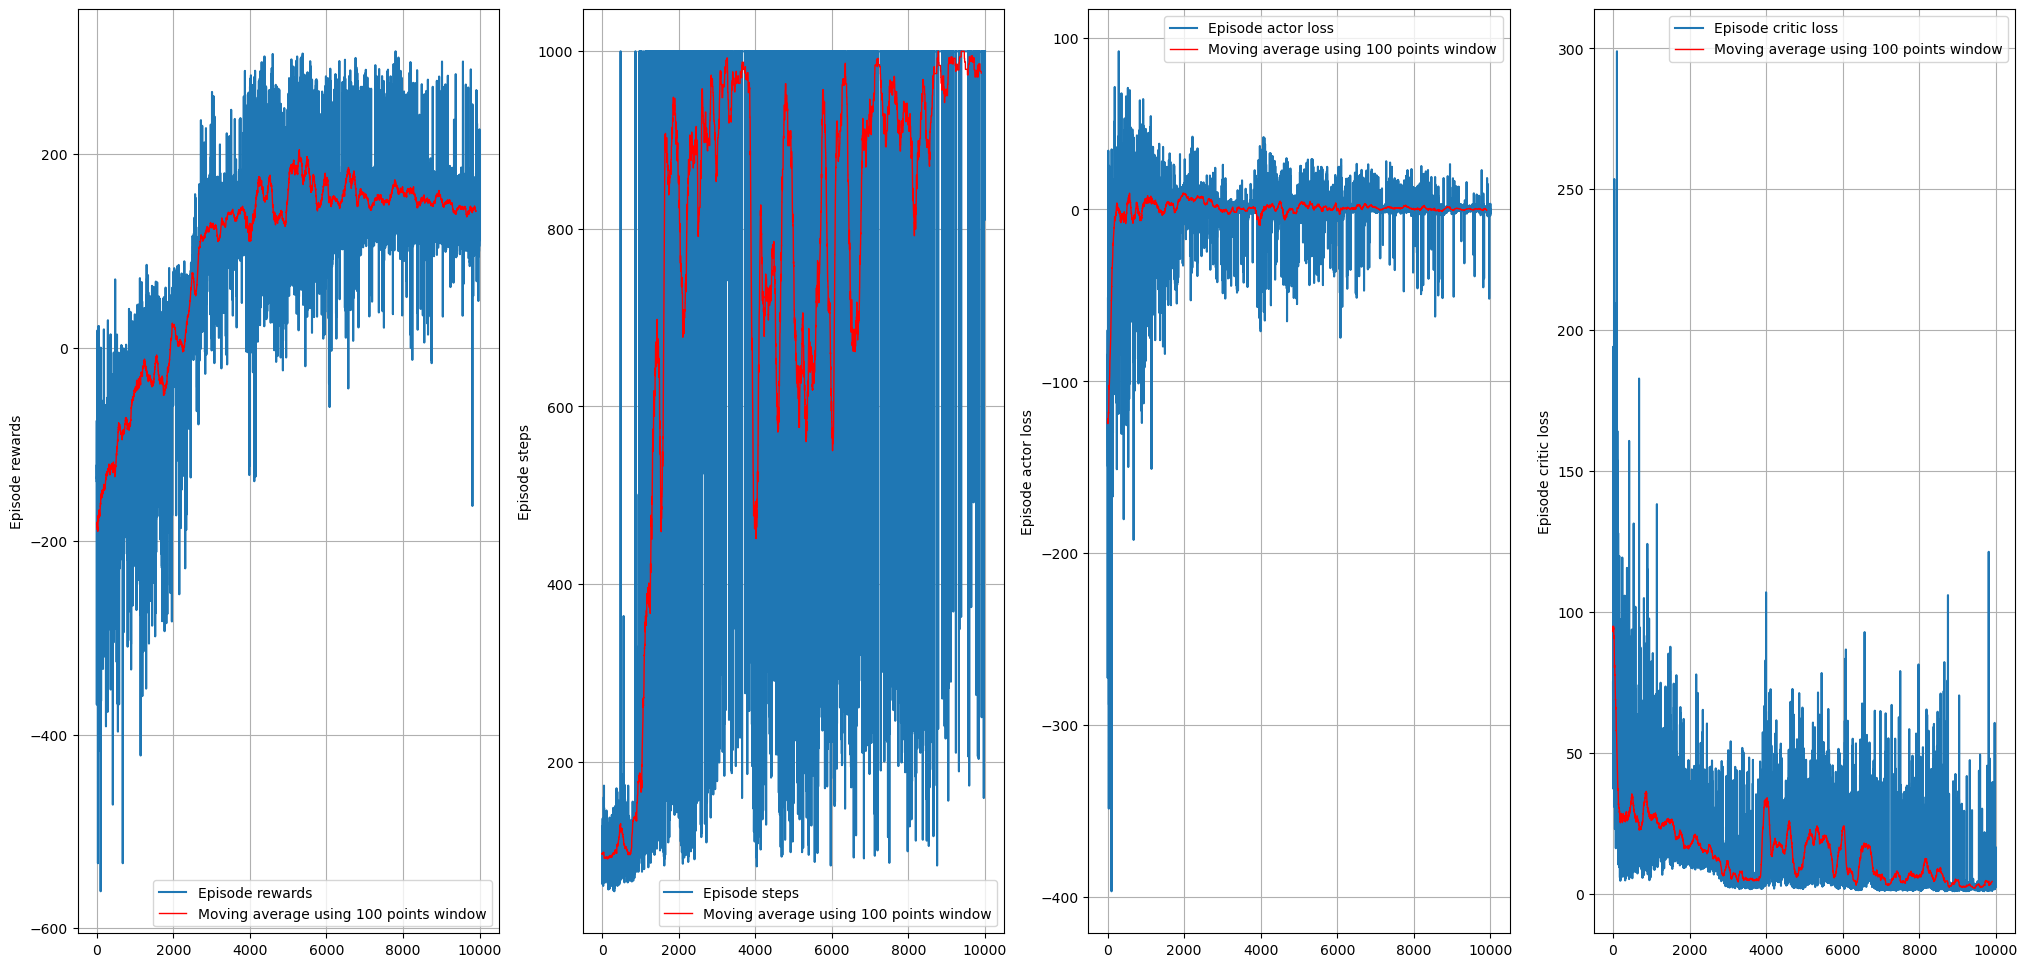

In [39]:
def actor_critic_impl(env, learning_rate, discount_factor, max_episodes, max_episode_steps):
    actor_model = ActorCritic_Actor_Model(env)
    critic_model = ActorCritic_Critic_Model(env)

    actor_model.train()
    critic_model.train()

    actor_optimizer = torch.optim.AdamW(actor_model.parameters(), lr=learning_rate)
    critic_optimizer = torch.optim.AdamW(critic_model.parameters(), lr=learning_rate)

    train_curves = defaultdict(list)

    for episode_i in tqdm(range(max_episodes)):
        log_episode_reward = 0
        log_episode_steps = 0

        # Store episode data needed to compute loss
        episode_action_probs = []       # list of tensors of selected actions
        episode_values = []  # list of tensors of state value estimations for each step
        episode_rewards = []            # list of rewards (scalars)

        state, info = env.reset()

        for step_i in range(max_episode_steps):

            state_tensor=torch.Tensor(state.reshape((1, -1)))

            action_probs = actor_model(state=state_tensor)

            value_estimate = critic_model(state_tensor)

            action = np.random.choice(action_probs.shape[1], p=action_probs.clone().detach().cpu().numpy()[0, :])

            state, reward, terminated, truncated, info = env.step(action)

            episode_action_probs.append(action_probs[0, action])
            episode_values.append(value_estimate.squeeze())
            episode_rewards.append(reward)

            log_episode_reward += reward
            log_episode_steps += 1

            if terminated or truncated:
                break

        T = len(episode_rewards)

        # discounted_returns = [
        #     rewards[0] + gamma * rewards[1] + gamma^2 * rewards[2] + ... + gamma^(T-2) * rewards[-2] + gamma^(T-1) * rewards[-1],
        #     rewards[1] + gamma * rewards[2] + gamma^2 * rewards[3] + ... + gamma^(T-2) * rewards[-1],
        #     ...
        #     rewards[-2] + gamma * rewards[-1],
        #     rewards[-1]
        # ]
        discounted_returns = np.zeros(T)
        discounted_returns[-1] = episode_rewards[-1]
        for time in range(T - 2, -1, -1):
            discounted_returns[time] = episode_rewards[time] + discount_factor * discounted_returns[time + 1]
        discounted_returns = torch.as_tensor(discounted_returns)

        policy_losses = []
        value_losses = []

        for time in range(T):
            discounted_return = discounted_returns[time]
            value_tensor = episode_values[time]
            # next_value_tensor = torch.zeros(1) if time == T - 1 else episode_values[time + 1]
            action_prob_tensor = episode_action_probs[time]

            # item() to avoid updating policy part
            advantage = discounted_return - value_tensor.item()
            policy_losses.append(torch.log(action_prob_tensor) * advantage)
            value_losses.append(torch.nn.functional.smooth_l1_loss(input=value_tensor, target=discounted_return))
            # value_losses.append(torch.pow(value_tensor - discounted_return, 2))  # Too lazy to test if that is better

        loss = -torch.mean(torch.stack(policy_losses))
        log_episode_actor_loss = loss.item()
        actor_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        actor_optimizer.step()

        loss = torch.mean(torch.stack(value_losses))
        log_episode_critic_loss = loss.item()
        critic_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        critic_optimizer.step()

        train_curves['Episode rewards'].append(log_episode_reward)
        train_curves['Episode steps'].append(log_episode_steps)
        train_curves['Episode actor loss'].append(log_episode_actor_loss)
        train_curves['Episode critic loss'].append(log_episode_critic_loss)

    return actor_model, critic_model, train_curves

def solve():
    env = gym.make('LunarLander-v2')

    actor_model, critic_model, train_curves = actor_critic_impl(
        env=env,
        learning_rate=3e-3,
        discount_factor=0.99,
        max_episodes=10000,
        max_episode_steps=1000)

    show_train_curves(train_curves)

    def __get_greedy_action_func(actor_model, state):
        action_probs = actor_model(
            state=torch.Tensor(state.reshape((1, -1))),
        )
        action_probs = action_probs.detach().cpu().numpy()[0, :]
        return np.argmax(action_probs)

    eval(
        env,
        actor_model,
        max_episodes=100,
        max_episode_steps=1000,
        get_action_func=__get_greedy_action_func)

    return env, actor_model, critic_model

env, actor_model, critic_model = solve()